# Simple Multi-Period Rankine Cycle with Price Taker Market Interaction

#### This example demonstrates how to use the MultiPeriod class to extend steady-state models to multiple time periods. We specifically show how a steady-state rankine cycle could be extended to use battery storage and track market price signals

First, we load necessary packages including rankine cycle and multiperiod functions

In [8]:
import pyomo.environ as pyo
import numpy as np
import copy
from random import random
from matplotlib import pyplot as plt

from simple_rankine_cycle import create_model, set_inputs, initialize_model, close_flowsheet_loop, add_operating_cost
from idaes.apps.multiperiod.multiperiod import MultiPeriodModel

# 1.) Create Steady-State Rankine Cycle Model

Create a function that returns a steady-state pyomo model for a rankine cycle. This could be exchanged for a more detailed plant model.

In [5]:
def create_ss_rankine_model():
    p_lower_bound = 300 #MW
    p_upper_bound = 450 #MW

    m = pyo.ConcreteModel()
    m.rankine = create_model(heat_recovery=True)
    m.rankine = set_inputs(m.rankine)
    m.rankine = initialize_model(m.rankine)
    m.rankine = close_flowsheet_loop(m.rankine)
    m.rankine = add_operating_cost(m.rankine)

    # set bounds for net cycle power output 
    m.rankine.fs.eq_min_power = pyo.Constraint(
        expr=m.rankine.fs.net_cycle_power_output >= p_lower_bound*1e6)

    m.rankine.fs.eq_max_power = pyo.Constraint(
        expr=m.rankine.fs.net_cycle_power_output <= p_upper_bound*1e6)

    m.rankine.fs.boiler.inlet.flow_mol[0].unfix()  #normally fixed 
    m.rankine.fs.boiler.inlet.flow_mol[0].setlb(1) #setting 0 causes numerical issues

    return m

# 2.) Import Locational Marginal Price (LMP) Data

We use representative prices from a Prescient simulation over the course of an entire year in the RTS-GMLC test system. We fix price spikes to $200/MWh since Prescient does not calculate prices for un-met load

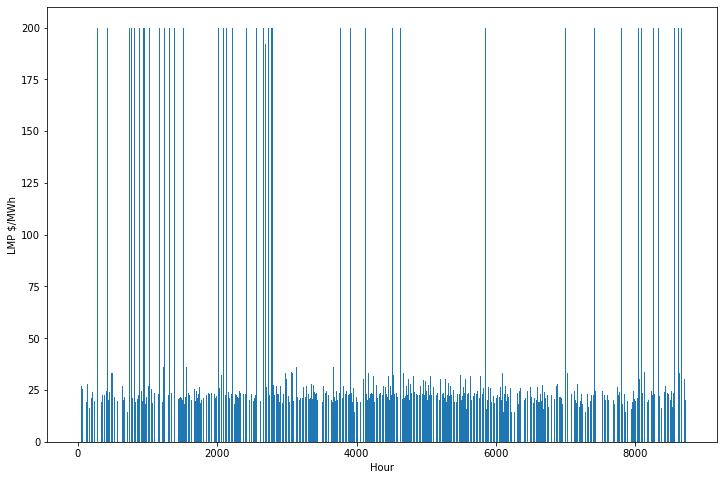

In [194]:
with open('rts_results_all_prices.npy', 'rb') as f:
    dispatch = np.load(f)
    price = np.load(f)
    
plt.figure(figsize=(12,8));
prices_used = copy.copy(price);
prices_used[prices_used > 200] = 200;
x = list(range(0,len(prices_used)));
plt.bar(x,(prices_used));
plt.xlabel("Hour");
plt.ylabel("LMP $/MWh");

## LMP for 6 Representative Weeks

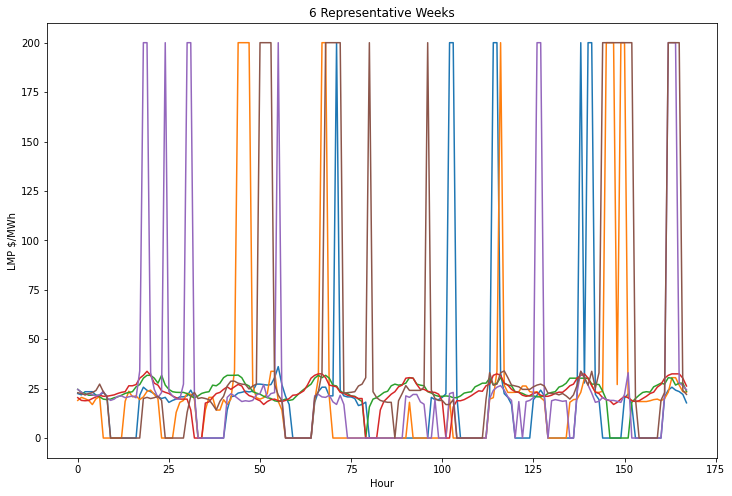

In [169]:
weekly_prices = prices_used.reshape(52,168);
plt.figure(figsize=(12,8));
for week in [0,15,25,35,45,51]:
    plt.plot(weekly_prices[week]);
plt.title("6 Representative Weeks")
plt.xlabel("Hour");
plt.ylabel("LMP $/MWh");

## LMP for 52 Representative Weeks

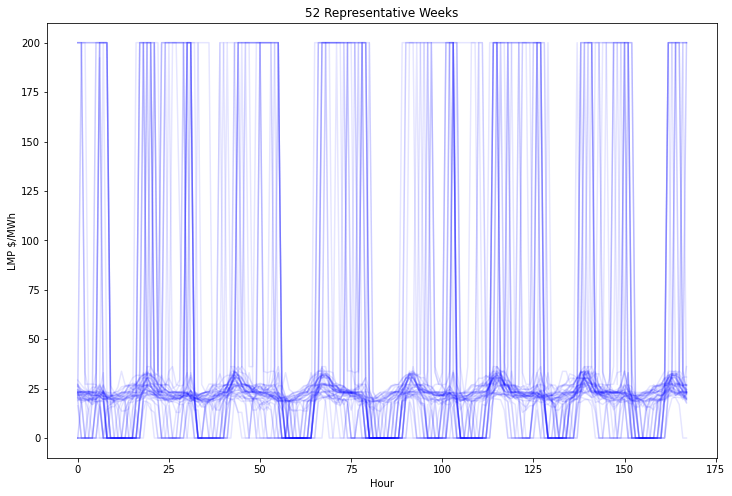

In [170]:
plt.figure(figsize=(12,8));
for week in range(0,52):
    plt.plot(weekly_prices[week],color = "blue", alpha = 0.1);
plt.title("52 Representative Weeks")
plt.xlabel("Hour");
plt.ylabel("LMP $/MWh");

# 3.) Create a Multiperiod-Capable Rankine Cycle Model

This is how a user should extend their steady-state process model to include time coupling.:  
1.) Decide which variables are coupled between time periods. These are variables which will include time-coupling constraints (e.g. ramping)  
2.) Create a function that builds a multi-period capable steady-state model (see code snippet 3.1)  
3.) Create functions that access the coupling variables given two pyomo blocks (see code snippet 3.2)

## 3.1) User-Defined Model Builder Function

This is passed to `MultiPeriodModel`. The user creates their steady-state model and then adds the extra capabilities for a multi-period version for a specific time period

In [103]:
turbine_ramp_rate = 100
battery_ramp_rate = 50
def create_mp_rankine_block():
    m = create_ss_rankine_model();
    b1 = m.rankine

    #Add coupling variable (next_power_output) to represent power output in next time period
    b1.power_output = pyo.Expression(expr = b1.fs.net_cycle_power_output*1e-6)  #MW
    b1.next_power_output = pyo.Var(within=pyo.NonNegativeReals, initialize=1.5) #MW

    #Use coupling variable to add ramping constraint
    b1.ramp1 = pyo.Constraint(expr=b1.power_output - b1.next_power_output <= turbine_ramp_rate)
    b1.ramp2 = pyo.Constraint(expr=b1.next_power_output - b1.power_output <= turbine_ramp_rate)

    #Add battery integration to rankine cycle
    b1.P_to_battery = pyo.Var(within=pyo.NonNegativeReals,initialize = 0.0) 
    b1.P_to_grid = pyo.Var(within=pyo.NonNegativeReals,initialize = 0.0)
    b1.P_total = pyo.Constraint(expr = b1.power_output == b1.P_to_battery + b1.P_to_grid)

    #Simple battery model (soc = state of charge). We create a coupling variable called next_soc
    m.battery = pyo.Block()
    b2=m.battery
    b2.soc = pyo.Var(within=pyo.NonNegativeReals,initialize=0.0, bounds=(0,100))
    b2.next_soc = pyo.Var(within=pyo.NonNegativeReals,initialize=0.0, bounds=(0,100))

    #Amount discharged to grid this time period (assume discharge is positive)
    b2.discharge = pyo.Var(initialize = 0.0)
    b2.energy_change = pyo.Constraint(expr = b2.next_soc == b2.soc - b2.discharge + b1.P_to_battery)
    b2.energy_down_ramp = pyo.Constraint(expr = b2.soc - b2.next_soc <= battery_ramp_rate)
    b2.energy_up_ramp = pyo.Constraint(expr = b2.next_soc - b2.soc <= battery_ramp_rate)
    return m

## 3.2) User-Defined Coupling Variable Functions

These functions also get passed to `MultiPeriodModel`. They are used to enforce coupling between time periods (get_rankine_link_variable_pairs) and enforce periodic conditions (get_rankine_periodic_variable_pairs)

In [104]:
#the power output and battery state are linked between time periods
def get_rankine_link_variable_pairs(b1,b2):
    return [(b1.rankine.next_power_output,b2.rankine.power_output),
            (b1.battery.next_soc,b2.battery.soc)]

#the final power output and battery state must be the same as the intial power output and battery state
def get_rankine_periodic_variable_pairs(b1,b2):
    return [(b1.rankine.next_power_output,b2.rankine.power_output),
            (b1.battery.next_soc,b2.battery.soc)]

# 4.) Create MultiPeriod Price-Taker Problem

Here we create the `MultiPeriodModel` using the developed functions. We assume a 1 week time period which creates 168 time blocks.

In [107]:
n_time_points = 7*24 #hours in a week

#create the multiperiod model object
mp_rankine = MultiPeriodModel(n_time_points=n_time_points, 
                              process_model_func=create_mp_rankine_block, 
                              linking_variable_func=get_rankine_link_variable_pairs,
                              periodic_variable_func = get_rankine_periodic_variable_pairs)

In [110]:
 #we pass in empty arguments for the data_kwargs (i.e. empty dictionaries)
time_points = np.arange(0,n_time_points)
data_points = [{} for i in range(n_time_points)]
data_kwargs = dict(zip(time_points,data_points))

#this will initialize each time block. note that it will take a few minutes
mp_rankine.build_multi_period_model(data_kwargs);

2021-08-31 11:17:29 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:29 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:30 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:30 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:30 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:30 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:30 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:30 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:30 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:32 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:32 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:32 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:32 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:32 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:32 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:32 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:32 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:32 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:34 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:34 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:34 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:34 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:34 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:34 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:34 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:34 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:34 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:36 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:36 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:36 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:36 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:36 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:36 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:36 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:36 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:37 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:39 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:39 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:39 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:39 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:39 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:39 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:39 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:39 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:39 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:41 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:41 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:42 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:42 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:42 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:42 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:42 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:42 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:42 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:43 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:43 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:44 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:44 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:44 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:44 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:44 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:44 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:44 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:45 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:45 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:45 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:45 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:45 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:45 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:46 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:46 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:46 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:48 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:48 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:49 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:49 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:49 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:49 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:49 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:49 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:49 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:51 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:51 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:51 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:51 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:51 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:51 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:51 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:51 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:51 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:53 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:53 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:53 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:53 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:53 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:53 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:53 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:53 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:53 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:55 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:55 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:55 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:55 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:55 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:55 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:55 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:55 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:55 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:17:59 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:17:59 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:59 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:59 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:17:59 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:59 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:17:59 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17:59 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:17:59 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:17

2021-08-31 11:18:01 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:01 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:02 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:02 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:02 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:02 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:02 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:02 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:02 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:04 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:04 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:04 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:04 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:04 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:04 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:04 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:04 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:04 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:06 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:06 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:06 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:06 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:06 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:06 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:06 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:06 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:06 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:08 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:08 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:08 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:08 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:08 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:08 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:08 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:08 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:08 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:10 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:10 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:10 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:10 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:10 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:10 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:10 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:10 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:10 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:12 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:12 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:12 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:12 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:12 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:12 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:12 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:12 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:12 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:14 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:14 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:14 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:14 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:14 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:14 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:14 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:14 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:14 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:16 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:16 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:16 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:16 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:16 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:16 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:16 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:16 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:16 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:18 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:18 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:18 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:18 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:18 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:18 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:18 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:18 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:19 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:20 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:20 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:20 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:20 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:20 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:20 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:20 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:20 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:20 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:22 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:22 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:22 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:22 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:23 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:23 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:23 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:23 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:23 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:24 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:24 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:24 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:24 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:24 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:24 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:24 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:24 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:25 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:26 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:26 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:26 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:26 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:26 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:26 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:26 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:26 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:26 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:28 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:28 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:28 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:28 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:28 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:28 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:28 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:28 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:28 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:30 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:30 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:30 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:30 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:30 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:30 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:30 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:30 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:30 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:32 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:32 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:33 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:33 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:33 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:33 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:33 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:33 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:33 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:35 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:35 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:35 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:35 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:35 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:35 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:35 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:35 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:35 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:36 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:36 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:36 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:36 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:37 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:37 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:37 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:37 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:37 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:38 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:38 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:38 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:38 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:38 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:38 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:38 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:38 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:39 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:40 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:40 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:40 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:40 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:40 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:40 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:41 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:41 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:41 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:42 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:42 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:42 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:42 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:43 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:43 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:43 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:43 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:43 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:44 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:45 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:45 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:45 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:45 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:45 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:45 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:45 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:45 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:47 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:47 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:47 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:47 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:47 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:47 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:47 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:47 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:47 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:48 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:49 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:49 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:49 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:49 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:49 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:49 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:49 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:49 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:51 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:51 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:51 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:51 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:51 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:51 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:51 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:51 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:51 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:53 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:53 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:53 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:53 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:53 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:53 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:53 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:53 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:53 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:54 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:54 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:55 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:55 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:55 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:55 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:55 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:55 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:55 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:56 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:56 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:57 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:57 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:57 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:57 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:57 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:57 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:57 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:18:58 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:18:58 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:58 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:59 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:18:59 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:59 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:18:59 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18:59 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:18:59 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:18

2021-08-31 11:19:01 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:01 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:01 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:01 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:01 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:01 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:01 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:01 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:01 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:03 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:03 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:03 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:03 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:03 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:03 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:03 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:03 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:03 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:04 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:04 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:07 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:07 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:07 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:07 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:07 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:07 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:07 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:09 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:09 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:09 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:09 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:09 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:09 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:09 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:09 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:09 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:11 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:11 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:11 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:11 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:11 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:11 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:11 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:11 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:12 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:13 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:13 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:13 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:13 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:13 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:13 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:13 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:13 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:14 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:15 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:15 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:16 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:16 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:16 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:16 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:16 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:16 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:16 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:18 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:18 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:18 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:18 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:18 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:18 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:18 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:18 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:18 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:20 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:20 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:20 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:20 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:20 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:20 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:20 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:20 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:20 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:22 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:22 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:22 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:22 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:22 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:22 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:22 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:22 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:22 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:25 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:25 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:25 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:25 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:25 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:25 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:25 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:25 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:25 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:27 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:27 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:27 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:27 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:27 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:27 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:27 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:27 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:27 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:29 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:29 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:29 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:29 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:29 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:29 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:29 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:29 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:29 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:32 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:32 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:32 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:32 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:32 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:32 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:32 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:32 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:32 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:34 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:34 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:34 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:34 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:34 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:34 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:34 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:34 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:34 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:36 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:36 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:36 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:36 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:36 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:36 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:36 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:36 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:36 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:38 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:38 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:38 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:38 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:39 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:39 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:39 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:39 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:39 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:41 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:41 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:41 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:41 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:41 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:41 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:41 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:41 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:41 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:43 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:43 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:43 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:43 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:43 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:43 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:43 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:43 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:44 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:45 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:45 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:45 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:45 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:45 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:45 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:45 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:45 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:46 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:47 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:47 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:47 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:47 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:47 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:47 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:47 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:47 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:48 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:50 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:50 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:50 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:50 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:50 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:50 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:50 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:50 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:50 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:52 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:52 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:52 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:52 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:52 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:52 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:52 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:52 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:52 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:54 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:54 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:54 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:54 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:54 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:54 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:54 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:54 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:54 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:55 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:55 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:56 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:56 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:56 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:56 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:56 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:56 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:56 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:57 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:57 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:58 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:58 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:19:58 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:58 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:19:58 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19:58 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:19:58 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:19

2021-08-31 11:19:59 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:19:59 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:00 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:00 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:00 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:00 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:00 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:00 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:00 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:02 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:02 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:02 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:02 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:02 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:02 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:02 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:02 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:02 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:04 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:04 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:04 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:04 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:04 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:04 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:04 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:04 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:04 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:06 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:06 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:06 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:06 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:06 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:06 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:06 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:06 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:06 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:08 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:08 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:08 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:08 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:08 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:08 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:08 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:08 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:08 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:09 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:10 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:10 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:10 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:10 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:10 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:10 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:10 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:10 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:12 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:12 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:12 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:12 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:12 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:12 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:12 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:12 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:12 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:14 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:14 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:14 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:14 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:14 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:14 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:14 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:14 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:14 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:16 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:16 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:16 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:16 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:16 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:16 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:17 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:17 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:17 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:19 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:19 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:19 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:19 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:19 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:19 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:19 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:19 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:19 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:21 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:21 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:21 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:21 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:21 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:21 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:21 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:21 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:21 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:23 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:23 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:23 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:23 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:23 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:23 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:23 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:23 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:24 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:25 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:25 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:25 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:25 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:25 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:25 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:26 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:26 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:26 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:27 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:27 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:27 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:27 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:27 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:27 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:27 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:27 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:28 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:29 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:29 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:29 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:29 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:29 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:29 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:29 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:29 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:30 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

2021-08-31 11:20:31 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-08-31 11:20:31 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:32 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:32 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-08-31 11:20:32 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:32 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-08-31 11:20:32 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20:32 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-08-31 11:20:32 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-08-31 11:20

## 4.1) Setup grid objective function and data

Now we query the produced pyomo blocks and create a LMP signal parameter on each block. We also add expressions for revenue (using plant dispatch and LMP) and cost (which is function of power output). We set the objective function to the summation of time period costs and also fix the initial battery state to initially be zero charge.

In [120]:
#retrieve pyomo model and active process blocks (i.e. time blocks)
m = mp_rankine.pyomo_model
blks = mp_rankine.get_active_process_blocks()

#add market data for each block
for blk in blks:
    blk_rankine = blk.rankine
    blk_battery = blk.battery
    blk.lmp_signal = pyo.Param(default=0,mutable=True)
    blk.revenue = blk.lmp_signal*(blk_rankine.P_to_grid + blk_battery.discharge)
    blk.cost = pyo.Expression(expr=-(blk.revenue - blk_rankine.fs.operating_cost))

m.obj = pyo.Objective(expr = sum([blk.cost for blk in blks]))
blks[0].battery.soc.fix(0);

    'pyomo.core.base.param.ScalarParam'>) on block blocks[0].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block blocks[0].process
    with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[1].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block blocks[1].process
    with a new Component (type=<class
    'pyomo.core.base.e

    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[11].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[12].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[12].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[13].process with a
    new Component (type=<class 'pyo

    'pyomo.core.base.param.ScalarParam'>) on block blocks[23].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[23].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[24].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[24].process with a new Component (type=<class
    'pyomo.core.ba

    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[34].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[35].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[35].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[36].process with a
    new Component (type=<class 'pyo

    'pyomo.core.base.param.ScalarParam'>) on block blocks[46].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[46].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[47].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[47].process with a new Component (type=<class
    'pyomo.core.ba

    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[57].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[58].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[58].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[59].process with a
    new Component (type=<class 'pyo

    'pyomo.core.base.param.ScalarParam'>) on block blocks[69].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[69].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[70].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[70].process with a new Component (type=<class
    'pyomo.core.ba

    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[80].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[81].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[81].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[82].process with a
    new Component (type=<class 'pyo

    'pyomo.core.base.param.ScalarParam'>) on block blocks[92].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[92].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[93].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[93].process with a new Component (type=<class
    'pyomo.core.ba

    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[103].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[104].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[104].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[105].process with a
    new Component (type=<class 

    'pyomo.core.base.param.ScalarParam'>) on block blocks[115].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[115].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[116].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[116].process with a new Component (type=<class
    'pyomo.cor

    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[126].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[127].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[127].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[128].process with a
    new Component (type=<class 

    'pyomo.core.base.param.ScalarParam'>) on block blocks[138].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[138].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[139].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[139].process with a new Component (type=<class
    'pyomo.cor

    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[149].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[150].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[150].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[151].process with a
    new Component (type=<class 

    'pyomo.core.base.param.ScalarParam'>) on block blocks[161].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[161].process with a new Component (type=<class
    'pyomo.core.base.expression.ScalarExpression'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.ScalarParam'>) on block blocks[162].process with a
    new Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.expression.ScalarExpression'>) on block
    blocks[162].process with a new Component (type=<class
    'pyomo.cor

## 4.2) Run the price-taker model

We run the price-taker model for 3 weeks by swapping out the LMP signal for each week and solving a new problem. This is generally a close approximation to running the entire year (if we set `n_weeks` to 52) because the only added constraint is a weekly periodic boundary condition (i.e. the power and battery state must get back to their initial value by end of the week)

We also record the state-of-charge `soc` and net power `net_power` for each optimization problem to plot later

In [131]:
n_weeks = 3
opt = pyo.SolverFactory('ipopt')
soc = []
net_power = []

for week in range(n_weeks):
    print(week)
    for (i,blk) in enumerate(blks):
        blk.lmp_signal = weekly_prices[week][i]    
    opt.solve(m,tee=False)
    soc.append([pyo.value(blks[i].battery.soc) for i in range(n_time_points)])
    net_power.append([pyo.value(blks[i].rankine.power_output) for i in range(n_time_points)])

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

  16 -1.3869705e+05 3.84e-02 5.17e+01  -1.0 1.31e+06    -  2.09e-01 4.87e-01h  1
  17 -1.3908428e+05 2.49e-02 8.96e+01  -1.0 6.74e+05    -  1.36e-01 3.51e-01h  1
  18 -1.3958046e+05 1.15e-02 1.51e+02  -1.0 4.37e+05    -  2.66e-01 5.38e-01h  1
  19 -1.3982624e+05 6.39e-03 2.46e+02  -1.0 2.02e+05    -  2.58e-01 4.44e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.4004779e+05 3.11e-03 6.47e+02  -1.0 1.13e+05    -  1.76e-01 5.14e-01h  1
  21 -1.4017802e+05 1.30e-03 1.00e+03  -1.0 1.07e+05    -  3.54e-01 5.81e-01h  1
  22 -1.4028831e+05 4.74e-04 3.09e+03  -1.0 1.66e+05    -  2.80e-01 6.36e-01h  1
  23 -1.4035899e+05 2.28e-04 3.33e+03  -1.0 2.30e+05    -  4.31e-01 5.19e-01h  1
  24 -1.4045115e+05 6.19e-05 1.76e+04  -1.0 4.05e+05    -  3.45e-01 7.28e-01h  1
  25 -1.4051277e+05 1.59e-05 2.76e+04  -1.0 6.19e+05    -  5.97e-01 7.43e-01h  1
  26 -1.4064667e+05 7.15e-07 1.91e+04  -1.0 1.54e+06    -  9.67e-01 1.00e+00h  1
  27 -1.4450156e+05 9.54e-07

 102 -3.3019482e+05 3.29e-04 2.08e+00  -8.6 3.73e+10    -  1.32e-03 1.12e-04f  1
 103 -3.3032804e+05 3.29e-04 2.08e+00  -8.6 5.86e+14    -  1.93e-10 6.84e-07f  1
In iteration 103, 1 Slack too small, adjusting variable bound
 104 -3.3032804e+05 3.29e-04 2.08e+00  -8.6 1.46e+10    -  4.32e-02 6.89e-11f  1
 105 -3.3033374e+05 3.15e-04 1.99e+00  -8.6 1.38e+08    -  1.19e-02 4.45e-02f  1
 106 -3.3038854e+05 3.15e-04 1.99e+00  -8.6 1.07e+17    -  4.48e-11 1.83e-09f  1
In iteration 106, 1 Slack too small, adjusting variable bound
 107 -3.3038854e+05 3.15e-04 1.99e+00  -8.6 9.22e+08    -  5.05e-01 5.33e-10f  1
 108 -3.3039349e+05 1.47e-04 9.28e-01  -8.6 3.53e+06    -  4.45e-01 5.33e-01f  1
 109 -3.3040932e+05 1.47e-04 9.28e-01  -8.6 5.79e+12    -  2.01e-09 3.47e-05f  1
In iteration 109, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.3040932e+05 1.47e-04 9.28e-01  -8.6 4.30e+07    -  1.00e+00 1.17e-08h  1
 111

  29 -1.0068208e+06 7.75e-07 4.92e+05  -1.0 2.40e+08    -  5.34e-02 9.28e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.0657098e+06 4.77e-07 4.74e+05  -1.0 3.85e+08    -  3.76e-02 4.79e-01f  1
  31 -1.0663319e+06 7.15e-07 2.38e+05  -1.0 2.04e+08    -  4.98e-01 9.26e-03f  1
  32 -1.0664960e+06 9.54e-07 1.87e+05  -1.0 2.02e+08    -  2.12e-01 3.07e-03f  1
  33 -1.0682773e+06 9.54e-07 1.47e+05  -1.0 2.02e+08    -  2.17e-01 3.74e-02f  1
  34 -1.0703534e+06 9.54e-07 1.38e+05  -1.0 2.24e+08    -  5.67e-02 3.38e-02f  1
  35 -1.0712997e+06 7.15e-07 1.27e+05  -1.0 2.22e+08    -  8.40e-02 1.61e-02f  1
  36 -1.0948324e+06 9.54e-07 1.12e+05  -1.0 2.17e+08    -  1.15e-01 3.72e-01f  1
  37 -1.1185557e+06 6.56e-07 9.04e+04  -1.0 2.04e+08    -  1.94e-01 4.26e-01f  1
  38 -1.1249174e+06 7.15e-07 5.09e+04  -1.0 1.26e+08    -  4.37e-01 2.10e-01f  1
  39 -1.1359335e+06 9.54e-07 2.52e+04  -1.0 9.04e+07    -  5.05e-01 4.98e-01f  1
iter    objective    inf_pr 

 119 -1.1528132e+06 1.19e-06 6.62e-01  -8.6 1.49e+08 -14.5 1.00e+00 1.32e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -1.1530890e+06 1.43e-06 5.92e-01  -8.6 1.81e+09 -15.0 4.51e-02 1.09e-01f  1
In iteration 120, 1 Slack too small, adjusting variable bound
 121 -1.1530890e+06 9.54e-07 4.97e-01  -8.6 1.63e+08 -14.6 7.41e-01 1.19e-09f  1
 122 -1.1533831e+06 1.19e-06 4.09e-01  -8.6 1.59e+09 -15.1 2.57e-02 1.64e-01f  1
 123 -1.1535305e+06 9.54e-07 3.74e-01  -8.6 1.90e+08 -14.7 2.52e-01 6.53e-02f  1
In iteration 123, 1 Slack too small, adjusting variable bound
 124 -1.1535305e+06 1.19e-06 3.74e-01  -8.6 4.88e+08 -15.1 7.89e-07 1.04e-09f  1
In iteration 124, 1 Slack too small, adjusting variable bound
 125 -1.1535305e+06 1.19e-06 3.74e-01  -8.6 1.98e+08 -14.7 7.96e-02 2.12e-06f  1
In iteration 125, 1 Slack too small, adjusting variable bound
 126 -1.1537100e+06 9.54e-07 2.89e-01  -8.6 7.42e+07 -14.3 1.50e-05 2.26e-01f  1
In iteration 126, 1 Sla

 196 -1.1615320e+06 8.34e-07 2.57e-07  -8.6 7.18e-06    -  1.00e+00 1.25e-01h  4
 197 -1.1615320e+06 8.34e-07 2.63e-07  -8.6 6.48e-06    -  1.00e+00 3.12e-02h  6
 198 -1.1615320e+06 8.34e-07 2.62e-07  -8.6 6.50e-06    -  1.00e+00 1.56e-02h  7
 199 -1.1615320e+06 8.34e-07 2.60e-07  -8.6 6.50e-06    -  1.00e+00 1.56e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -1.1615320e+06 8.34e-07 2.57e-07  -8.6 6.50e-06    -  1.00e+00 1.56e-02h  7
 201 -1.1615320e+06 7.15e-07 1.29e-07  -8.6 6.50e-06    -  1.00e+00 5.00e-01h  2
 202 -1.1615320e+06 7.15e-07 2.84e-14  -8.6 3.38e-06    -  1.00e+00 1.00e+00h  1
 203 -1.1615320e+06 9.54e-07 2.84e-14  -8.6 7.18e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 203

                                   (scaled)                 (unscaled)
Objective...............:  -5.8076598163184908e+05   -1.1615319632636982e+06
Dual infeasibility......:   2.8421709430404007e-14    5.6843418860808015e-14
Constraint vio

## 4.3) Plot Battery State-of-Charge and LMP 

Plot the battery state for 1 week of operation. This should show that the battery is frequently utilized throughout each day.

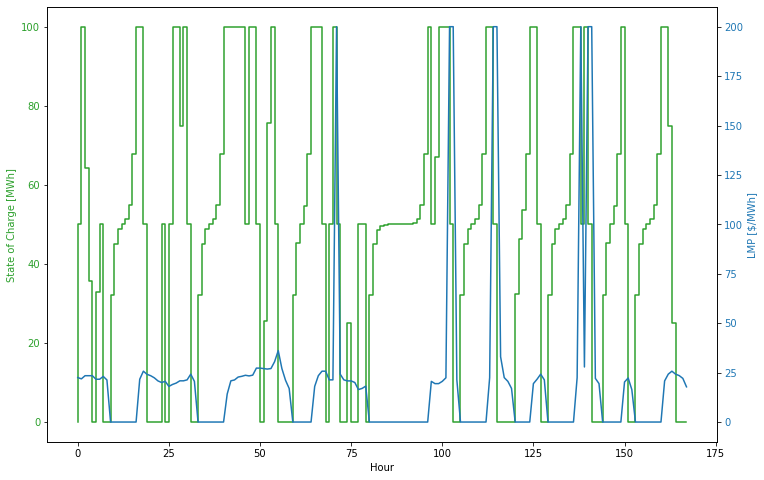

In [191]:
n_weeks_to_plot = 1;
hours = np.arange(n_time_points*n_weeks_to_plot);
lmp_array = weekly_prices[0:n_weeks_to_plot].flatten();
soc_array = np.asarray(soc[0:n_weeks_to_plot]).flatten();

fig, ax1 = plt.subplots(figsize=(12,8));

color = 'tab:green';
ax1.set_xlabel('Hour');
ax1.set_ylabel('State of Charge [MWh]', color=color);
ax1.step(hours,soc_array, color=color);
ax1.tick_params(axis='y', labelcolor=color);

ax2 = ax1.twinx();  
color = 'tab:blue';
ax2.set_ylabel('LMP [$/MWh]', color=color);
ax2.plot(hours,lmp_array, color=color);
ax2.tick_params(axis='y', labelcolor=color);

## 4.4) Plot Power-Output and LMP 

Plot the hourly power output. This should show the output tracks price spikes.

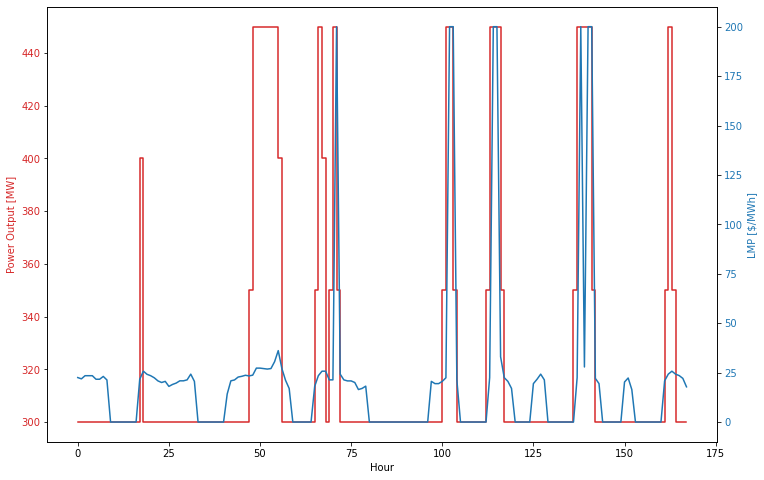

In [192]:
n_weeks_to_plot = 1;
hours = np.arange(n_time_points*n_weeks_to_plot);
lmp_array = weekly_prices[0:n_weeks_to_plot].flatten();
power_array = np.asarray(net_power[0:n_weeks_to_plot]).flatten();

fig, ax1 = plt.subplots(figsize=(12,8));

color = 'tab:red';
ax1.set_xlabel('Hour');
ax1.set_ylabel('Power Output [MW]', color=color);
ax1.step(hours,power_array, color=color);
ax1.tick_params(axis='y', labelcolor=color);

ax2 = ax1.twinx();  
color = 'tab:blue';
ax2.set_ylabel('LMP [$/MWh]', color=color);
ax2.plot(hours,lmp_array, color=color);
ax2.tick_params(axis='y', labelcolor=color);